# Faiz Essa
## Google Trends Event Studies
### March 10, 2023

In [66]:
# Importing packages
import os
import pandas as pd
import linearmodels as lm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [67]:
# Defining Functions

def GenerateDummies(df, event_time):
    ''' Inputs a data frame and event time and outputs a dataframe with dummy variables for days in event window,
    as well as pre-event-window and post-event-window dummys.
    '''
    # generate a variable that details time to event
    df["weeks_to_event"] = df["time"] - event_time 
    
    # creating PreEventWindow and PostEventWindow variables
    df.loc[df["weeks_to_event"] < -8, "PreEventWindow"] = 1
    df.loc[df["weeks_to_event"] >= -8, "PreEventWindow"] = 0
    df.loc[df["weeks_to_event"] > 8, "PostEventWindow"] = 1
    df.loc[df["weeks_to_event"] <= 8, "PostEventWindow"] = 0
    
    # Creating lags and leads for event window 
    df.loc[(df["weeks_to_event"] >= -8) & (df["weeks_to_event"] <= 8), \
                      "window"] = df["weeks_to_event"] 
    
    # adding in dummies 
    df = pd.get_dummies(df, prefix = "weeks_to_event", columns =["window"])
    
    # Interacting dummies with WhatsAppInterest
    # leads
    df["lead9"] = df["PreEventWindow"] * df["WhatsAppInterest"]
    df["lead8"] = df["weeks_to_event_-8.0"] * df["WhatsAppInterest"]
    df["lead7"] = df["weeks_to_event_-7.0"] * df["WhatsAppInterest"]
    df["lead6"] = df["weeks_to_event_-6.0"] * df["WhatsAppInterest"]
    df["lead5"] = df["weeks_to_event_-5.0"] * df["WhatsAppInterest"]
    df["lead4"] = df["weeks_to_event_-4.0"] * df["WhatsAppInterest"]
    df["lead3"] = df["weeks_to_event_-3.0"] * df["WhatsAppInterest"]
    df["lead2"] = df["weeks_to_event_-2.0"] * df["WhatsAppInterest"]

    # lags
    df["lag0"] = df["weeks_to_event_0.0"] * df["WhatsAppInterest"]
    df["lag1"] = df["weeks_to_event_1.0"] * df["WhatsAppInterest"]
    df["lag2"] = df["weeks_to_event_2.0"] * df["WhatsAppInterest"]
    df["lag3"] = df["weeks_to_event_3.0"] * df["WhatsAppInterest"]
    df["lag4"] = df["weeks_to_event_4.0"] * df["WhatsAppInterest"]
    df["lag5"] = df["weeks_to_event_5.0"] * df["WhatsAppInterest"]
    df["lag6"] = df["weeks_to_event_6.0"] * df["WhatsAppInterest"]
    df["lag7"] = df["weeks_to_event_7.0"] * df["WhatsAppInterest"]
    df["lag8"] = df["weeks_to_event_8.0"] * df["WhatsAppInterest"]
    df["lag9"] = df["PostEventWindow"] * df["WhatsAppInterest"]
    
    # set index (State is 'Entity' and year-week is 'time')
    df = df.set_index(["GAULADM1Code", "time"])
    
    return df


def GenerateESPlot(fit):
    ''' Inputs point estimates of an event-study and ouputs a plot
    '''
    # create dataframe for event study plot
    es_plot_data = pd.concat([fit.params, fit.std_errors], axis = 1)

    # drop constant
    es_plot_data = es_plot_data.drop("const")

    # Scale standard error to 95% CI
    es_plot_data['ci'] = es_plot_data['std_error']*1.96
    
    # remove "lead" and "lag" text
    es_plot_data.index = (
        es_plot_data.index
            .str.replace('lead', '-')
            .str.replace('lag', '')
            .astype('int')
            .rename('weeks_to_policy')
    )
    
    # add row for -1 w/ 0 values
    new_row = [0, 0, 0]
    es_plot_data.loc[-1] = new_row
    
    # sort data by index
    es_plot_data = es_plot_data.sort_index()
    
    # generating plot
    es_plot = es_plot_data.plot(y = "parameter", yerr = "ci", \
                                xlabel = "Weeks to Policy", ylabel = "Estimated Effect", legend = False)
    es_plot.axhline(0, linestyle='dashed')
    es_plot.axvline(0, linestyle='dashed')

In [68]:
# Set working directory
os.chdir('/Users/faizessa/Library/CloudStorage/Dropbox/Mac/Documents/GitHub/WhatsApp-and-Collective-Action')

This file details the results of event studies examining how WhatsApp policy changes effect protests. The raw data is formatted as a panel detailing the number of protests each week from 2015 to 2021 in each Indian State. We also have data on WhatsApp interest from google trends for each Indian state. The WhatsApp data comes from *[here](https://trends.google.com/trends/explore?date=2017-07-09%202018-07-09&geo=IN&q=%2Fm%2F0gwzvs1&hl=en)*.

View a preview of the data below:

In [69]:
# Importing data
protest_panel = pd.read_csv("Data/GDELT/gtrends_es_panel.csv")
print(protest_panel)
# preview of data: 

      GAULADM1Code  WhatsAppInterest  year  week  time  protest_count
0             IN25               100  2015     1     1              0
1             IN25               100  2015     2     2              0
2             IN25               100  2015     3     3              0
3             IN25               100  2015     4     4              5
4             IN25               100  2015     5     5              0
...            ...               ...   ...   ...   ...            ...
13170         IN30                43  2022    50   421              0
13171         IN30                43  2022    51   422              1
13172         IN30                43  2022    52   423              0
13173         IN30                43  2022    53   424              0
13174         IN30                43  2023     1   425              0

[13175 rows x 6 columns]


I examine the following 5 policies:
 1. 10th July 2018 - forwarded messages labeled
 2. 18th July 2018 - WhatsApp forwards can be sent to only 5 chats at a time in India and 20 chats everywhere else (this is only one week after the previous policy).
 3. 21st July 2019 - WhatsApp forwards limited to 5 chats worldwide
 4. 2nd/3rd April 2019 - WhatsApp launched a fact-check service to combat fake news & Privacy settings to control who has permission to add people to groups (these changes were in the same week).
 5. 7th April 2020 - WhatsApp messages that have already been forwarded by 5 or more people can only be forwarded to 1 chat


In [70]:
# Creates dataframes for each event

# Labelling forwarded messages (10th July 2018, time = 187)
forward_label_data = GenerateDummies(protest_panel, 187)

# WhatsApp forwards can be sent to only 5 chats at a time in India and 20 chats everywhere else (18th July 2018, time =188)
# note this is just one week following the previous change
forward_limit_1_data = GenerateDummies(protest_panel, 188)

# WhatsApp forwards limited to 5 chats worldwide (21 Jan 2019, time = 216)
forward_limit_2_data = GenerateDummies(protest_panel, 216)

# WhatsApp launched a fact-check service to combat fake news (2nd Apr 2019, time = 226)
# Privacy settings to control who has permission to add people to groups (3rd Apr 2019, time = 226)
# these two changes are at the same time
fact_check_data = GenerateDummies(protest_panel, 226)


# WhatsApp messages that have already been forwarded by 5 or more people can only be forwarded to 1 chat (7 Apr 2020, time = 280)
# week after policies above
forward_limit_3_data = GenerateDummies(protest_panel, 280)




I employ the following OLS regression to study the effects of WhatsApp policy changes:

$\mathrm{Protests}_{st} = \alpha + \beta_{-9} (\mathrm{PreEventWindow}_t \times \mathrm{WhatsAppInterest}_{s}) + \sum_{i \in [-8, 8]\setminus \{-1\}} \beta_i (i\_\mathrm{WeeksToEvent}_{t} \times \mathrm{WhatsAppInterest}_{s}) + \beta_{9} (\mathrm{PostEventWindow}_t \times \mathrm{WhatsAppInterest}_{s}) + \gamma_{s} + \eta_{t} + \varepsilon_{st}$

$s$ indexes state and $t$ indexes year-week groups. 

I include only the interaction terms because others are colinear with fixed effects.

In [71]:
# REGRESSIONS

# RHS variables are out leads and lags
exog_vars = ["lead9", "lead8", "lead7", "lead6", "lead5", "lead4", "lead3", "lead2", \
       "lag0", "lag1", "lag2", "lag3", "lag4", "lag5", "lag6", "lag7", "lag8", "lag9"]

# Executing regressions

# Labelling forwarded messages (10th July 2018, time = 187)
forward_label_mod = lm.PanelOLS(forward_label_data["protest_count"], \
                                sm.add_constant(forward_label_data[exog_vars]), \
                                entity_effects = True, time_effects = True)
forward_label_fit = forward_label_mod.fit(cov_type ='clustered', cluster_entity = True)

# WhatsApp forwards can be sent to only 5 chats at a time in India and 20 chats everywhere else (18th July 2018, time =188)
# note this is just one week following the previous change
forward_limit_1_mod = lm.PanelOLS(forward_limit_1_data["protest_count"], \
                                sm.add_constant(forward_limit_1_data[exog_vars]), \
                                entity_effects = True, time_effects = True)
forward_limit_1_fit = forward_limit_1_mod.fit(cov_type ='clustered', cluster_entity = True)

# WhatsApp forwards limited to 5 chats worldwide (21 Jan 2019, time = 216)
forward_limit_2_mod = lm.PanelOLS(forward_limit_2_data["protest_count"], \
                                 sm.add_constant(forward_limit_2_data[exog_vars]), \
                                 entity_effects = True, time_effects = True)
forward_limit_2_fit = forward_limit_2_mod.fit(cov_type = 'clustered', cluster_entity = True)

# WhatsApp launched a fact-check service to combat fake news (2nd Apr 2019, time = 226)
# Privacy settings to control who has permission to add people to groups (3rd Apr 2019, time = 226)
# these two changes are at the same time
fact_check_mod = lm.PanelOLS(fact_check_data["protest_count"], \
                                 sm.add_constant(fact_check_data[exog_vars]), \
                                 entity_effects = True, time_effects = True)
fact_check_fit = fact_check_mod.fit(cov_type = 'clustered', cluster_entity = True)

# WhatsApp messages that have already been forwarded by 5 or more people can only be forwarded to 1 chat (7 Apr 2020, time = 280)
forward_limit_3_mod = lm.PanelOLS(forward_limit_3_data["protest_count"], \
                                 sm.add_constant(forward_limit_3_data[exog_vars]), \
                                 entity_effects = True, time_effects = True)
forward_limit_3_fit = forward_limit_3_mod.fit(cov_type = 'clustered', cluster_entity = True)



### 1. 10th July 2018 - forwarded messages labeled

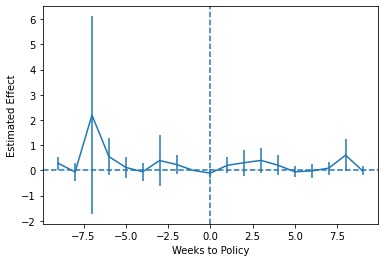

In [72]:
GenerateESPlot(forward_label_fit)
# view the event study plot for the forward label policy change below

In [73]:
forward_label_fit.summary
# view point estimates for forward label policy change below

Dep. Variable:,protest_count,R-squared:,0.0045
Estimator:,PanelOLS,R-squared (Between):,0.0163
No. Observations:,13175,R-squared (Within):,-0.0319
Date:,"Fri, Mar 10 2023",R-squared (Overall):,-0.0122
Time:,17:26:15,Log-likelihood,-6.84e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.2132
Entities:,31,P-value,0.0000
Avg Obs:,425.00,Distribution:,"F(18,12702)"
Min Obs:,425.00,,
Max Obs:,425.00,F-statistic (robust):,1.8165


### 2. 18th July 2018 - WhatsApp forwards can be sent to only 5 chats at a time in India and 20 chats everywhere else

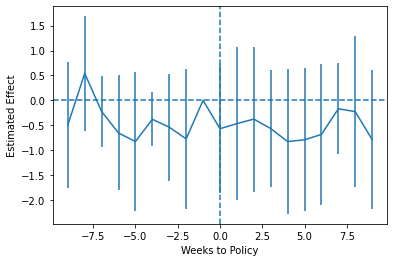

In [74]:
GenerateESPlot(forward_limit_1_fit)
# view the event study plot for the first forward limit below

In [75]:
forward_limit_1_fit.summary
# view point estimates for the first forward limit below

Dep. Variable:,protest_count,R-squared:,0.0039
Estimator:,PanelOLS,R-squared (Between):,-0.1694
No. Observations:,13175,R-squared (Within):,-0.0235
Date:,"Fri, Mar 10 2023",R-squared (Overall):,-0.0830
Time:,17:26:16,Log-likelihood,-6.841e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.7440
Entities:,31,P-value,0.0001
Avg Obs:,425.00,Distribution:,"F(18,12702)"
Min Obs:,425.00,,
Max Obs:,425.00,F-statistic (robust):,1.6003


### 3. 21st July 2019 - WhatsApp forwards limited to 5 chats worldwide

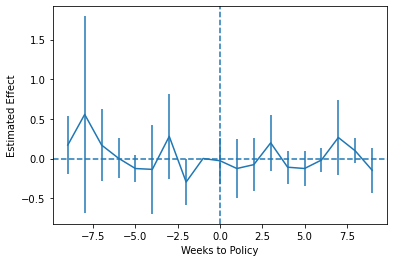

In [76]:
GenerateESPlot(forward_limit_2_fit)
# view the event study plot for the second forward limit below

In [77]:
forward_limit_2_fit.summary
# view point estimates for the second forward limit below

Dep. Variable:,protest_count,R-squared:,0.0040
Estimator:,PanelOLS,R-squared (Between):,0.0024
No. Observations:,13175,R-squared (Within):,-0.0258
Date:,"Fri, Mar 10 2023",R-squared (Overall):,-0.0143
Time:,17:26:16,Log-likelihood,-6.841e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.8530
Entities:,31,P-value,0.0000
Avg Obs:,425.00,Distribution:,"F(18,12702)"
Min Obs:,425.00,,
Max Obs:,425.00,F-statistic (robust):,2.5260


### 4. 2nd/3rd April 2019 - WhatsApp launched a fact-check service to combat fake news & Privacy settings to control who has permission to add people to groups

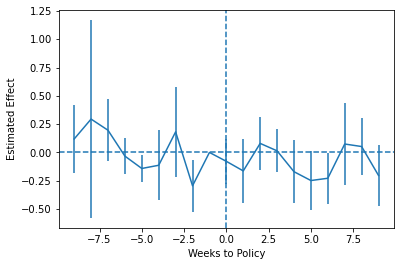

In [78]:
GenerateESPlot(fact_check_fit)
# view event study plot for the fact checking policy below

In [79]:
fact_check_fit.summary
# view point estimates for the fact checking policy below

Dep. Variable:,protest_count,R-squared:,0.0038
Estimator:,PanelOLS,R-squared (Between):,-0.0052
No. Observations:,13175,R-squared (Within):,-0.0236
Date:,"Fri, Mar 10 2023",R-squared (Overall):,-0.0161
Time:,17:26:16,Log-likelihood,-6.841e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,2.7125
Entities:,31,P-value,0.0001
Avg Obs:,425.00,Distribution:,"F(18,12702)"
Min Obs:,425.00,,
Max Obs:,425.00,F-statistic (robust):,3.3745


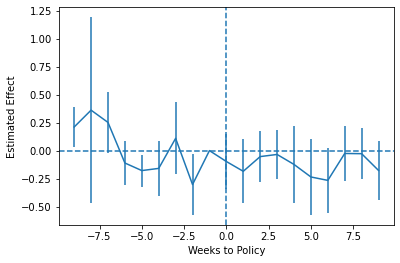

In [80]:
# view the event study plot for the third forward limit below
GenerateESPlot(forward_limit_3_fit)

### 5. 7th April 2020 - WhatsApp messages that have already been forwarded by 5 or more people can only be forwarded to 1 chat

In [81]:
forward_limit_3_fit.summary
# view point estimates for the third forward limit below

Dep. Variable:,protest_count,R-squared:,0.0051
Estimator:,PanelOLS,R-squared (Between):,0.0098
No. Observations:,13175,R-squared (Within):,0.0005
Date:,"Fri, Mar 10 2023",R-squared (Overall):,0.0043
Time:,17:26:16,Log-likelihood,-6.84e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.5996
Entities:,31,P-value,0.0000
Avg Obs:,425.00,Distribution:,"F(18,12702)"
Min Obs:,425.00,,
Max Obs:,425.00,F-statistic (robust):,3.1404
